# Constructing selection functions: DR3 RVS as an example

In this notebook, we discuss the general core problem faced in constructing a selection function, and a simple solution developed for the RVS selection function for Gaia DR3.

## The selection function problem: two different approaches

As we discuss in [Getting started with gaiaunlimited](getting-started.ipynb), a selection function is the probability as a function of appropriate (catalog) variables that an entry in the parent set is included in the subset of interest. Generally speaking, there are two categories of solutions to coming up wiht this probability:

1. from understanding and modelling all steps involved in the experimental design of constructing the subset (note that the "subset" could be the entire `gaia_source` catalog in this context) or
2. from comparing with the ground truth of all things that could have been included.

Although the first solution is appealing in that we build our understanding of the experiemnt from the ground up, often times it is not feasible to account for all the nitty-gritty details of all steps involved in an experiment as complex as e.g., Gaia source catalog construction. For an example of such approach still simplified for Gaia DR2, interested readers are refered to [Boubert & Everall 2020][BE2020].

Thus, we consider the second approach which aims to come up with a probability function that describes the binary outcome (in the subset or not in the subset). Let us consider the simpliest case: a coin toss. This is when the probability function is just a scalar.

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import healpy as hp
import astropy.coordinates as coord
import astropy.units as u
# plt.style.use('notebook')

## Coin toss

Given binary outcome data, how do we estimate the probability? This problem is often described using a coin toss example: say we toss a coin $n$ times, and each time the coin will show either heads or tails. Let's call the number of times that it showed heads $k$. How do we estimate the probability that the coin will show head in the next throw?

The random variable $Y$ which is the number of times the coin shows heads is related to the probability $p$ through the **binomial distribution**:

$$ Y \sim \mathrm{Binomial}(n, p)$$
$$ P(Y=k) = \left(\begin{matrix} n \\ k \end{matrix} \right) p^k (1-p)^{n-k}$$

In Bayesian estimation of the posterior probability of $p$, a natural choice of prior distribution for $p$ is the **Beta distribution**. The beta distribution can be thought of as a probability distribution of probabilities: it is a distribution defined between 0 and 1. The Beta distribution is described by the two shape parameters often referred to as $\alpha$ and $\beta$. The Beta distribution can show a variety of behaviours depending on the two shape parameters but roughly speaking, when $\alpha,\,\beta>1$, we can think of it describing the probability given $\alpha-1$ successes and $\beta-1$ failures (although there is no reason why $\alpha,\,\beta$ should be integers). Thus, if $\alpha \gt \beta > 1$, it will prefer higher (success) probability and vice versa.

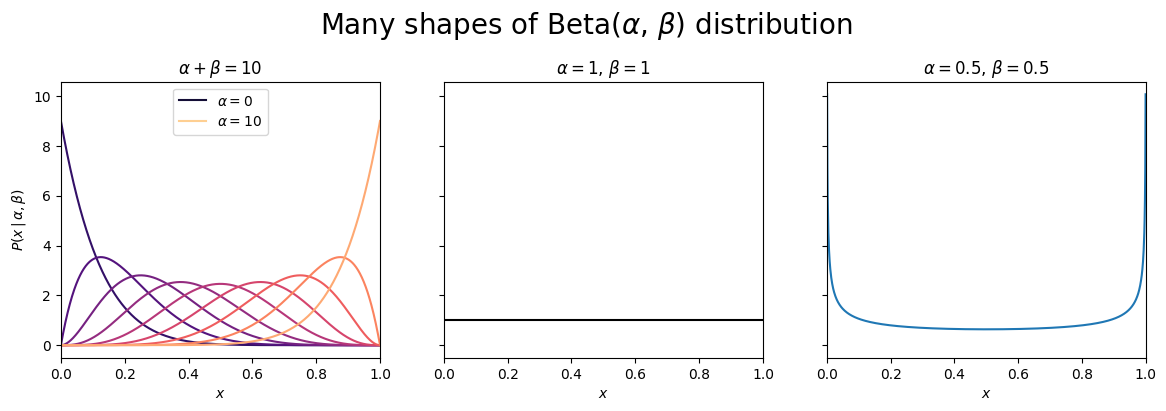

In [2]:
def plot_beta():
    fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(14,4), sharey=True, sharex=True)
    xs = np.linspace(0,1,1001)
    for alpha in np.arange(0,11):
        px = stats.beta(alpha, 10-alpha).pdf(xs)
        if alpha in [0, 10]:
            label=rf'$\alpha={alpha}$'
        else:
            label=None
        ax1.plot(xs, px, c=plt.cm.magma(alpha/10.0 * 0.8 + 0.1), label=label)
    ax1.set(xlabel="$x$", ylabel=r"$P(x\,|\,\alpha,\beta)$", title=r"$\alpha+\beta=10$");
    ax1.legend(loc='upper center')
    px = stats.beta(1, 1).pdf(xs)
    ax2.plot(xs, px, 'k-')
    ax2.set(title=r"$\alpha=1$, $\beta=1$",  xlabel='$x$');
    px = stats.beta(0.5, 0.5).pdf(xs)
    ax3.plot(xs, px);
    ax3.set(xlim=(0,1), xlabel="$x$", title=r"$\alpha=0.5$, $\beta=0.5$");
    fig.subplots_adjust(top=0.8)
    fig.suptitle(r"Many shapes of Beta($\alpha$, $\beta$) distribution", size=20);
plot_beta()

Why is the beta distribution a "natural" choise? Because it is a conjugate prior probability distribution for the binomial distribution, meaning that the posterior probability of $p$ is also a Beta distribution (updated according to the data). In fact, the posterior update seems quite natural as well:

$$
    \begin{align}
        &p \sim \mathrm{Beta}(\alpha,\beta);\; Y \sim \mathrm{Binomial}(n, p) \\
        \Rightarrow& P(p\,|\,Y=k,\alpha,\beta) = \mathrm{Beta}(k+\alpha, n-k + \beta)
    \end{align}
$$

It is like we are adding the result of our experiment which showed $k$ successes and $n-k$ failures to $\alpha$ and $\beta$!

If we assume a uniform prior distribution ($\alpha=\beta=1$; see the figure above), our posterior distribution of $p$ is

$$ \mathrm{Beta}(k+1, n-k+1) $$

Since $\mathrm{Beta}(\alpha,\beta)$ has the mean $\alpha/(\alpha+\beta)$, the mean of the posterior distribution is

$$ \boxed{ \frac{k+1}{n+2} }$$

This approaches the naive estimate $k/n$ as $k$ and $n$ gets larger.

The variance of a Beta distribution $\mathrm{Beta}(\alpha,\beta)$ is $\alpha\beta/(\alpha+\beta)^2 (\alpha+\beta+1)$. Thus, the variance of the posterior distribution of $p$ is

$$ \frac{(k+1)(n-k+1)}{(n+2)^2 (n+3)} $$


Below we show this posterior update for true $p=0.73$ (red line) for the first 100 throws. The blue line is the mean of the posterior distribution at each update.

![](_static/animated-coin.gif)

## Astronomical selection functions

In the context of astronomical selection functions, what changes from this simple picture?
First, the binary outcome now corresponds to whether a source in the parent set is included or not included in the subset under consideration. Second, the probability function is usually multi-dimensional. The selection probability usually will depend on the apparent magnitude of the source as observations have a finite depth, sky position as the coverage may vary, and potentially other factors such as local source crowdedness or local source magnitude distribution.


## DR3 RVS selection function

Based on the discussion above, the current version of the DR3 RVS Selection function, which we define as the [subsample selection function](getting-started.ipynb#subsample-selection-functions) for the subsample that has an RV measured (`radial_velocity IS NOT NULL` to be exact in the Gaia Archive), assumes the selection function depends on sky position, Gaia $G$, and Gaia $G-RP$. We further simply that the selection function is piece-wise constant in each pixel in this three-dimensional space after pixelising the sky position at HEAL order 5, $G$ in 0.2 magnitude and $G-RP$ in 0.4 magnitude. In each bin, the selection probability is estimated as the mean of the posterior (Beta) distribution.

Below we sample and compare this DR3 RVS subsample selection function with that for EDR3 by [Everall et al. 2022][Everall+2022] using a different method. Note that in [Everall et al. 2022][Everall+2022], the RVS sample is further required to have more than 3 RV transits, and this introduces a much more prominent scanning-law-dependent pattern.

In [3]:
from gaiaunlimited.selectionfunctions import DR3RVSSelectionFunction, EDR3RVSSelectionFunction
from gaiaunlimited.utils import get_healpix_centers

edr3_rvssf = EDR3RVSSelectionFunction()
rvssf = DR3RVSSelectionFunction()

In [4]:
def plot_rvs(gval, cval):
    cc = get_healpix_centers(5)
    prob_edr3 = edr3_rvssf.query(cc, g=np.ones_like(cc, dtype=float)*gval,
                                 c=np.ones_like(cc, dtype=float)*cval) 
    prob = rvssf.query(cc, g=np.ones_like(cc, dtype=float)*gval, c=np.ones_like(cc, dtype=float)*cval)

    fig = plt.figure(figsize=(10,3))
    hp.mollview(prob_edr3, fig=fig, sub=121, title='EDR3 (Everall+2022)',
                margins=[0,0,0,0.1], min=0, max=1)
    hp.mollview(prob, fig=fig, sub=122, title='DR3',
                margins=[0,0,0,0.1], min=0, max=1)
    fig.suptitle(f"G={gval:.1f}, G-RP={cval:.1f}", size=20);
    return fig

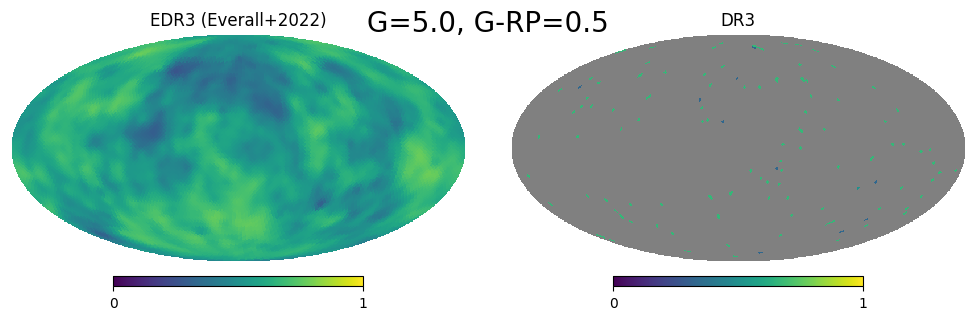

In [5]:
plot_rvs(5,.5);

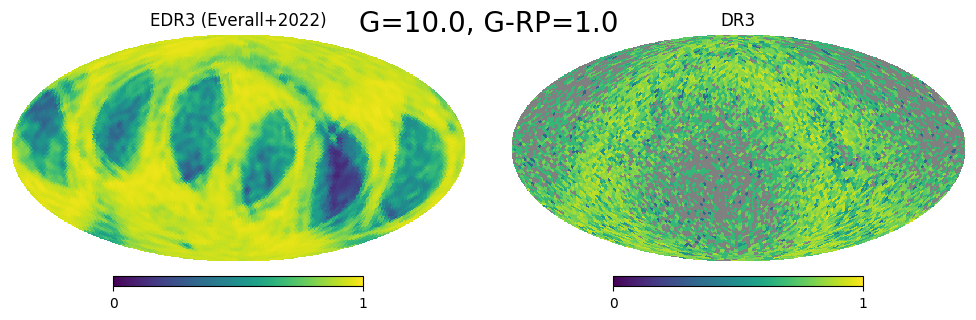

In [6]:
plot_rvs(10,1);

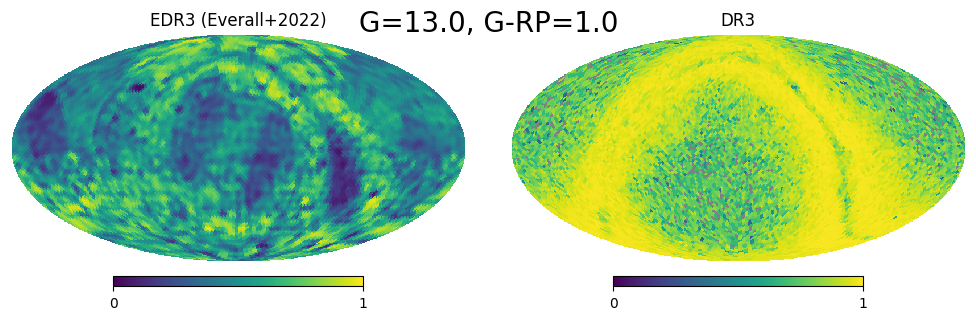

In [7]:
plot_rvs(13,1);

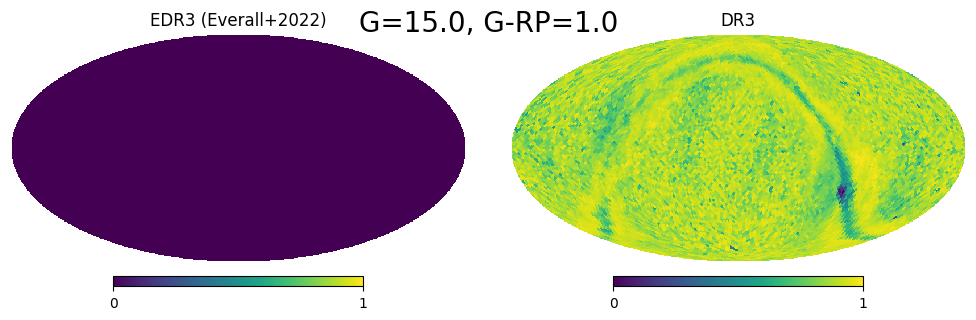

In [8]:
plot_rvs(15,1);

[BE2020]: https://ui.adsabs.harvard.edu/abs/2020MNRAS.497.4246B/abstract
[Everall+2022]: https://ui.adsabs.harvard.edu/abs/2022MNRAS.509.6205E/abstract